In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
from pathlib import Path
import sys
import yaml
import matplotlib.pyplot as plt
sys.path.append("../../")

In [4]:
from pytorch_toolbox.pipeline import Pipeline, load_config_from_path
from pytorch_toolbox.utils.vision import tensor2img
from src.train_with_template import lookups
from src.image import plot_rgby

#### Load the configuration file needed to construct the DAG for the pipeline

In [5]:
CONFIG_FILE_PATH = Path("../configs/config.yml")

In [6]:
config = load_config_from_path(CONFIG_FILE_PATH, with_variable_replacement=True)

In [7]:
pipeline = Pipeline.create_from_config(config, lookups)

In [8]:
pipeline.sorted_node_names

['CheckIfRunInferenceModelSavePath',
 'CreateInferenceModelSavePath',
 'CreateResultRecorder',
 'CreateTimeStampedSavePath',
 'RunRecordResults',
 'SaveConfiguration',
 'CreateTensorBoardRecorderLearnerCallback',
 'CreateCSVLoggerLearnerCallback',
 'CreateSaveModelCallback',
 'CreateFiveCropTTAPredictionCallback',
 'CreateGradientClippingLearnerCallback',
 'CreateLabelExtractorCallback',
 'CreateCallbacksForInference',
 'CreateCallbacks',
 'CreateLovaszHingeFlatLoss',
 'CreateSoftF1Loss',
 'CreateFocalLoss',
 'CreateFocalLossMetric',
 'CreateF1SoftMetric',
 'CreateAccuracyMetric',
 'CreateModel',
 'CreateLearnerForInference',
 'CreateTrainingScheme',
 'CreateDenormalizeFunction',
 'CreateOutputRecorderLearnerCallback',
 'CreateLearnerCallbacks',
 'CreateLearner',
 'CreateNormalizeFunction',
 'CreateFiveCropTTAFunction',
 'CreateTestAugmentationFunction',
 'CreateAugmentationFunction',
 'CreateOpenImageFunction',
 'CreateTestingDataset',
 'CreateDataBunchForInference',
 'CreateInference

#### Get the nodes needed to create the learner

In [9]:
pipeline.run(to_node="CreateDataBunch")

In [10]:
split_idxs = pipeline.get_node_output("CreateSplitIndices")
create_data_bunch = pipeline.get_node_output("CreateDataBunch")
create_learner = pipeline.get_node_output("CreateLearner")
normalization_function = pipeline.get_node_output("CreateNormalizeFunction")
denormalization_function = pipeline.get_node_output("CreateDenormalizeFunction")

In [12]:
train_idx, val_idx = next(split_idxs)

In [13]:
data_bunch = create_data_bunch(train_idx, val_idx)

#### Uncomment below to see the output of the data loader

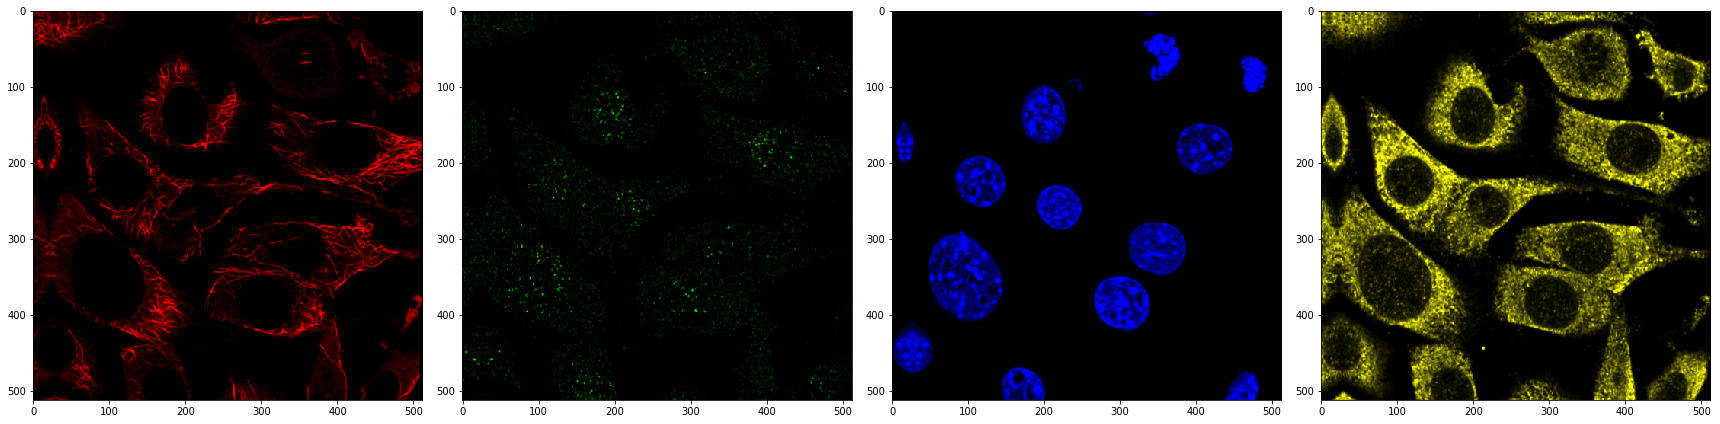

In [14]:
train_image_batch, _ = next(iter(data_bunch.train_dl))
train_image = train_image_batch[0]
plot_rgby(tensor2img(train_image, denormalize_fn=denormalization_function, scale_factor=1.0))

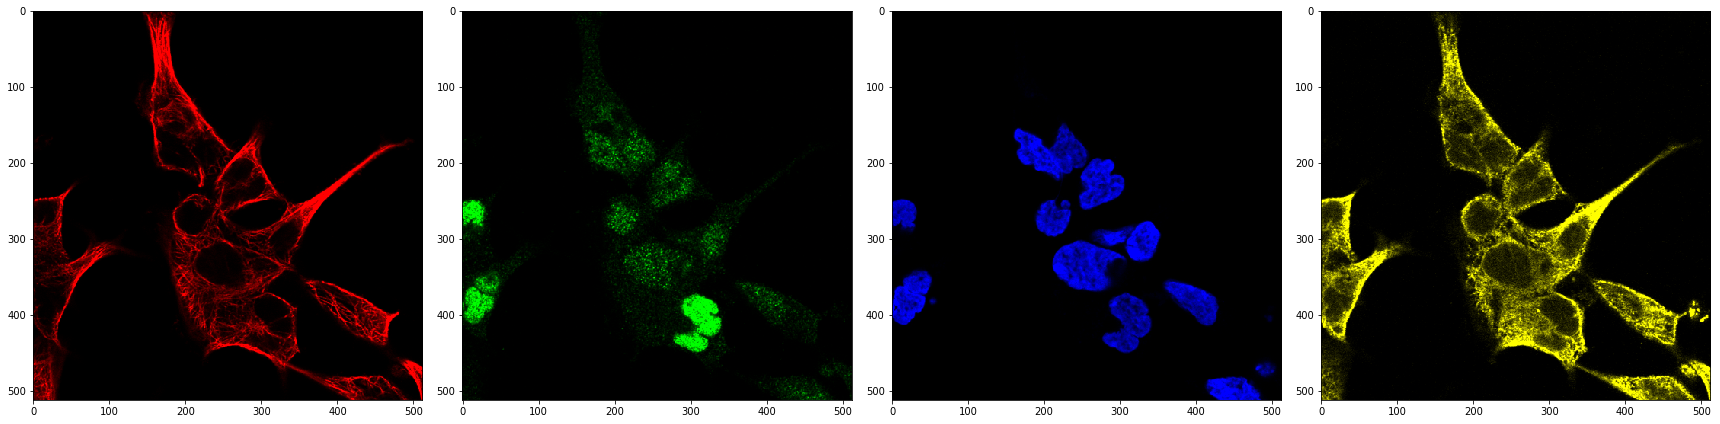

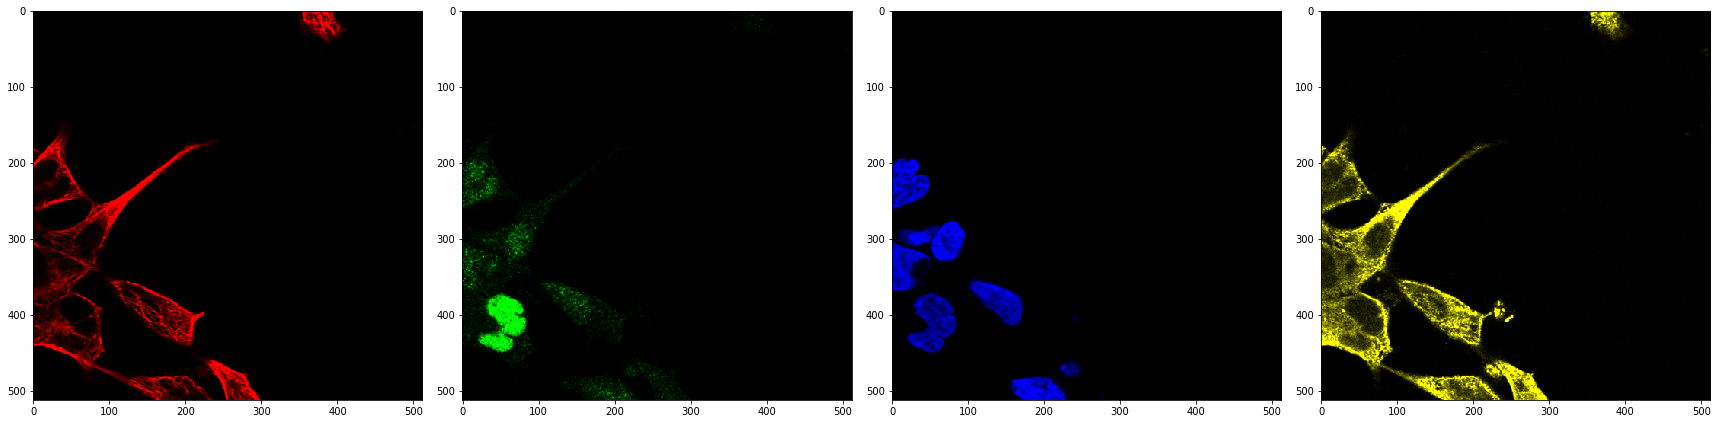

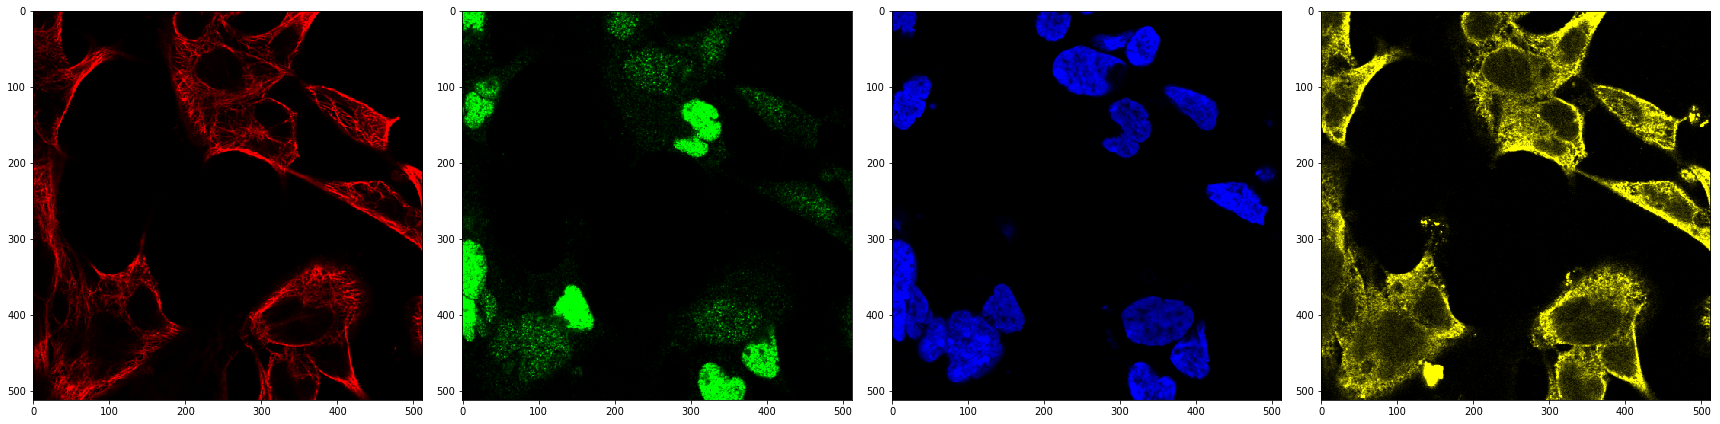

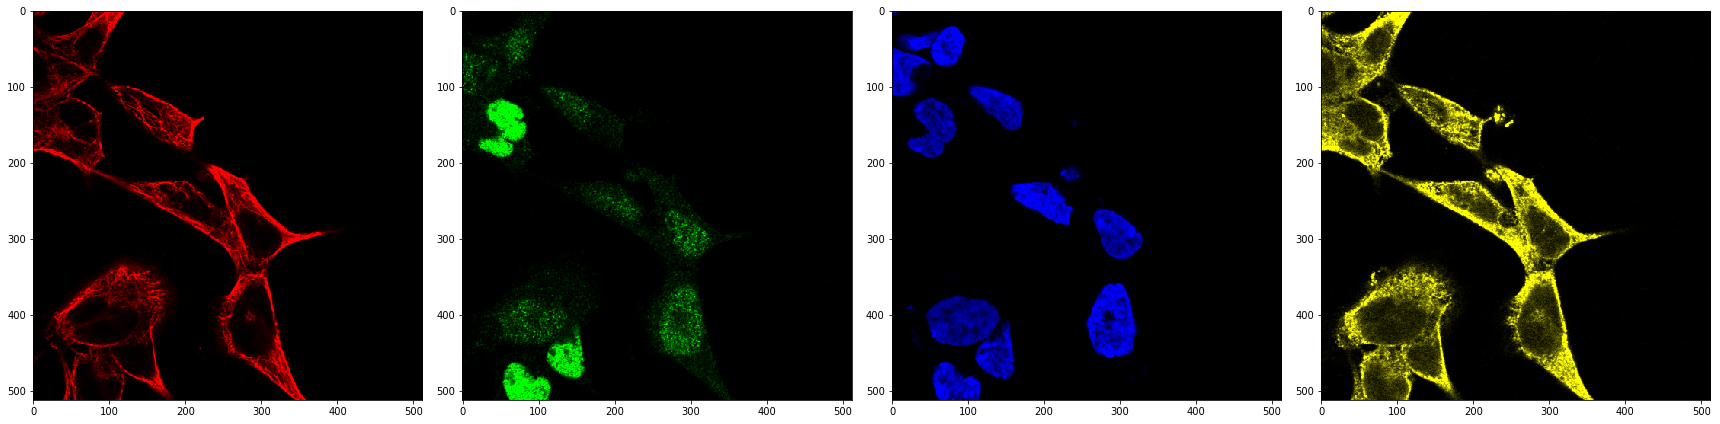

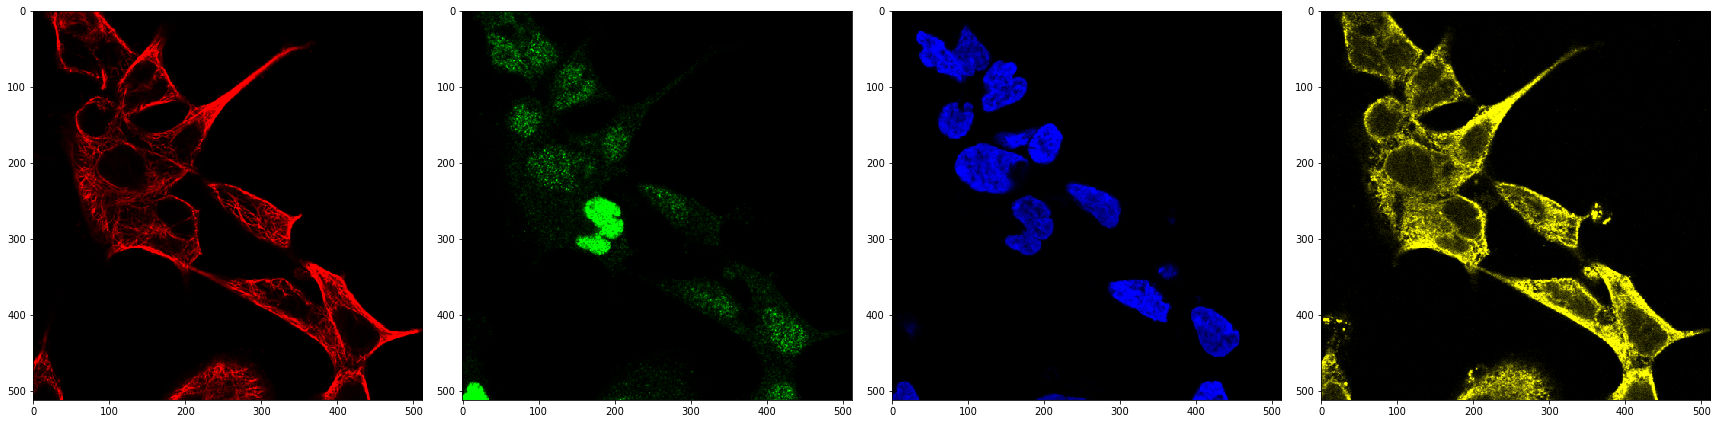

In [15]:
five_crop_images, _ = next(iter(data_bunch.valid_dl))
five_crop_image = five_crop_images[0]
for crop in five_crop_image:
    plot_rgby(tensor2img(crop, denormalize_fn=denormalization_function, scale_factor=1.0))

#### Find the optimal learning rate

In [16]:
N_ITERS = 333

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


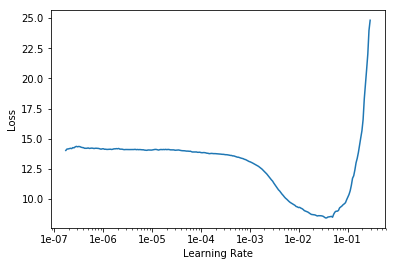

In [17]:
learner = create_learner(data_bunch)
learner.lr_find(num_it=N_ITERS)
learner.recorder.plot()

In [18]:
for lr, loss in zip(learner.recorder.lrs[10:-5], learner.recorder.losses[10:-5]):
    print(lr, loss)

1.7387624002162505e-07 tensor(14.0354)
1.8376562003881712e-07 tensor(14.1511)
1.9421746814890257e-07 tensor(14.1590)
2.052637752709252e-07 tensor(14.1811)
2.1693835183851848e-07 tensor(14.2125)
2.2927693128656491e-07 tensor(14.1863)
2.4231727942375993e-07 tensor(14.2720)
2.5609931002584584e-07 tensor(14.2496)
2.7066520700332413e-07 tensor(14.3305)
2.860595535175742e-07 tensor(14.3717)
3.0232946844057774e-07 tensor(14.3380)
3.1952475057592117e-07 tensor(14.3645)
3.3769803108250907e-07 tensor(14.3504)
3.569049345675229e-07 tensor(14.3042)
3.772042493416998e-07 tensor(14.2766)
3.98658107358044e-07 tensor(14.2643)
4.213321743847288e-07 tensor(14.2144)
4.4529585099426546e-07 tensor(14.2162)
4.706224849841282e-07 tensor(14.2148)
4.973895958790064e-07 tensor(14.2438)
5.256791122018422e-07 tensor(14.2029)
5.555776222398876e-07 tensor(14.2146)
5.871766390733256e-07 tensor(14.2293)
6.205728806776502e-07 tensor(14.2201)
6.558685659571431e-07 tensor(14.1946)
6.931717276155406e-07 tensor(14.2147)
7